In [1]:
import pandas as pd
import numpy as np
import os
import h5py as h5
import sqlalchemy as sa
import tomllib

from pathlib import Path

### postgis method

In [3]:
HOURS_PER_YEAR = 8760
secret = tomllib.load(open("./secret.toml", "rb"))

def get_db_engine():
    url = sa.engine.URL.create(
        drivername="postgresql+psycopg",
        database=secret["atlas"]["database"],
        host=secret["atlas"]["hostname"],
        username=secret["atlas"]["username"],
        password=secret["atlas"].get("password"),  # optional, if not specified will search for .pgpass
    )
    return sa.create_engine(url)

with get_db_engine().connect() as con:
    agentbtm = pd.read_sql_query(
        sql="""--sql
        select a.gid, r.run_id, countyfp, statefp, turbine_class, wind_aep_kwh, techpot_kw, r.capacity_kw, application, rev_gid_wind, rev_index_wind, geom 
        from dwind.result as r
        join dwind.agent as a on r.gid = a.gid
        join dwind.breakeven_threshold bt on bt.run_id = r.run_id and bt.capacity_kw = r.capacity_kw
        where
        	r.run_id = 6
            and a.countyfp = '53023'
            and r.breakeven_cost > 0 --bt.breakeven_threshold
        """,
        con=con,
    )
print(agentbtm.shape)

(127, 12)


In [4]:
#merge btm and fom
'''if agentfom.empty and agentbtm.empty:
    print(f"  Skipping county: no agent data.")
else:
    agent = pd.concat([agentfom, agentbtm]).reset_index(drop=True)

#start
duplicates = agent[agent.duplicated(subset="gid", keep=False)].reset_index(drop=True)
print(f"Found {len(duplicates)} duplicate rows for {duplicates['gid'].nunique()} unique gids")

agent = agent.loc[
    agent.groupby('gid')['capacity_kw'].idxmax()
].sort_index()'''

# agent = agentbtm.copy()

#prefers FOM by choosing row with higher capacity_kw when 'gid' is a duplicate. change to idxmin for BTM preference

'if agentfom.empty and agentbtm.empty:\n    print(f"  Skipping county: no agent data.")\nelse:\n    agent = pd.concat([agentfom, agentbtm]).reset_index(drop=True)\n\n#start\nduplicates = agent[agent.duplicated(subset="gid", keep=False)].reset_index(drop=True)\nprint(f"Found {len(duplicates)} duplicate rows for {duplicates[\'gid\'].nunique()} unique gids")\n\nagent = agent.loc[\n    agent.groupby(\'gid\')[\'capacity_kw\'].idxmax()\n].sort_index()'

In [5]:
# Re-label application
agent = agentbtm
agent.loc[agent.application=="FOM, Utility","application"]="FOM"
agent.loc[agent.application=="BTM, FOM, Utility","application"]="BTM, FOM"
# fix normal/time series result problem by adjusting turbine class to match capacity_kw!
turbine_class_dict = {
    2.5: "res",
    5.0: "res",
    10.0: "res",
    20.0: "res",
    50.0: "com",
    100.0: "com",
    250.0: "mid",
    500.0: "mid",
    750.0: "mid",
    1000.0: "large",
    1500.0: "large"
}

agent["turbine_class"] = agent["capacity_kw"].map(turbine_class_dict)

agent

,gid,run_id,countyfp,statefp,turbine_class,wind_aep_kwh,techpot_kw,capacity_kw,application,rev_gid_wind,rev_index_wind,geom
0,3fdf050c-3a2c-4201-9775-9edebd741e60,6,53023,53,res,12139.356445,1000.0,2.5,BTM,847127,255039,0101000020E6100000000000E0F9605DC000000080C03D...
1,515f6215-08fa-4e35-9618-ef4d4e7a0503,6,53023,53,res,10355.147461,250.0,2.5,BTM,829589,246593,0101000020E6100000000000002C735DC0000000207042...
2,297144ca-55a0-4e86-ac2c-430d63aef9ad,6,53023,53,res,9050.542969,2.5,2.5,BTM,841281,252221,0101000020E610000000000000A5645DC0000000C0DA3C...
3,f2bc3751-4357-4481-9aaf-2435c5172089,6,53023,53,res,18882.521484,5.0,5.0,BTM,849074,255977,0101000020E6100000000000007F5B5DC0000000C09238...
4,58ad8c55-eb3b-494d-b902-917edb872b26,6,53023,53,res,9866.866211,10.0,2.5,BTM,852981,257868,0101000020E610000000000080B65B5DC000000020E44D...
...,...,...,...,...,...,...,...,...,...,...,...,...
122,08640c08-17ac-4130-834f-f885cd19e271,6,53023,53,res,11801.955078,100.0,2.5,"BTM, FOM",835428,249398,0101000020E61000000000000009655DC0000000C02C2F...
123,97ba06cf-df38-403b-86dd-667483c8c9db,6,53023,53,res,8915.791992,2.5,2.5,"BTM, FOM",839332,251282,0101000020E610000000000000A0655DC000000060673C...
124,e96346bf-0f97-4d80-9fd1-46126a05a654,6,53023,53,res,8915.791992,2.5,2.5,"BTM, FOM",839332,251282,0101000020E6100000000000C0A7645DC000000040BC3C...
125,81b21802-e7b0-46e6-9e2e-f43866bda5ee,6,53023,53,res,9289.283203,50.0,2.5,"BTM, FOM",851031,256926,0101000020E610000000000060A95C5DC0000000001E4E...


In [6]:
def get_rev_timeseries_wind(turbine_class, rev_index_wind, year=2012):
    path_rev_wind = Path("/projects/dwind/data/rev/") / f"rev_{turbine_class:s}_generation_{year:d}.h5"

    rev_index_wind = np.sort(np.array(rev_index_wind, dtype=int))

    with h5.File(path_rev_wind.resolve(), "r") as hf:
        slice_step, mod = divmod(hf["cf_profile"].shape[0], HOURS_PER_YEAR)
        if mod != 0:
            raise NotImplementedError()

        scale_factor = hf["cf_profile"].attrs.get("scale_factor", 1000.0)
        cf_profile = hf["cf_profile"][slice(None, None, slice_step), rev_index_wind].T

    cf_profile = np.divide(cf_profile, scale_factor, dtype=np.float64)

    cf_profile = pd.Series(
        list(cf_profile),
        index=pd.Index(rev_index_wind, name="rev_index_wind"),
        name="cf_profile_hourly",
    )
    return cf_profile

In [7]:
rev_lkup = pd.read_csv("/projects/dwind/configs/rev/wind/lkup_rev_index_2012_to_2018.csv")
agent = agent.merge(rev_lkup, left_on="rev_index_wind", right_on="rev_index_wind_2018")
agent = agent.drop(columns=["rev_index_wind", "rev_index_wind_2018"])
agent = agent.rename(columns={"rev_index_wind_2012": "rev_index_wind"})

turbine_class_rev_index = agent.groupby("turbine_class")["rev_index_wind"].unique()

turbine_class_rev_index = pd.concat(
    objs={
        turbine_class: get_rev_timeseries_wind(turbine_class, rev_indexes)
        for turbine_class, rev_indexes in turbine_class_rev_index.items()
    },
    names=["turbine_class"],
)

agent = agent.merge(
    turbine_class_rev_index,
    left_on=turbine_class_rev_index.index.names,
    right_index=True,
)
agent

,gid,run_id,countyfp,statefp,turbine_class,wind_aep_kwh,techpot_kw,capacity_kw,application,rev_gid_wind,geom,rev_index_wind,cf_profile_hourly
0,3fdf050c-3a2c-4201-9775-9edebd741e60,6,53023,53,res,12139.356445,1000.0,2.5,BTM,847127,0101000020E6100000000000E0F9605DC000000080C03D...,262966,"[0.059, 0.229, 0.68, 0.626, 0.664, 0.687, 0.64..."
1,515f6215-08fa-4e35-9618-ef4d4e7a0503,6,53023,53,res,10355.147461,250.0,2.5,BTM,829589,0101000020E6100000000000002C735DC0000000207042...,254400,"[0.12, 0.272, 0.569, 0.626, 0.705, 0.732, 0.74..."
2,297144ca-55a0-4e86-ac2c-430d63aef9ad,6,53023,53,res,9050.542969,2.5,2.5,BTM,841281,0101000020E610000000000000A5645DC0000000C0DA3C...,260108,"[0.056, 0.184, 0.677, 0.661, 0.744, 0.778, 0.7..."
3,f2bc3751-4357-4481-9aaf-2435c5172089,6,53023,53,res,18882.521484,5.0,5.0,BTM,849074,0101000020E6100000000000007F5B5DC0000000C09238...,263917,"[0.078, 0.339, 0.641, 0.63, 0.645, 0.683, 0.62..."
4,58ad8c55-eb3b-494d-b902-917edb872b26,6,53023,53,res,9866.866211,10.0,2.5,BTM,852981,0101000020E610000000000080B65B5DC000000020E44D...,265835,"[0.017, 0.123, 0.492, 0.739, 0.664, 0.713, 0.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,08640c08-17ac-4130-834f-f885cd19e271,6,53023,53,res,11801.955078,100.0,2.5,"BTM, FOM",835428,0101000020E61000000000000009655DC0000000C02C2F...,257245,"[0.32, 0.264, 0.229, 0.158, 0.168, 0.081, 0.08..."
123,97ba06cf-df38-403b-86dd-667483c8c9db,6,53023,53,res,8915.791992,2.5,2.5,"BTM, FOM",839332,0101000020E610000000000000A0655DC000000060673C...,259155,"[0.071, 0.207, 0.625, 0.59, 0.715, 0.744, 0.73..."
124,e96346bf-0f97-4d80-9fd1-46126a05a654,6,53023,53,res,8915.791992,2.5,2.5,"BTM, FOM",839332,0101000020E6100000000000C0A7645DC000000040BC3C...,259155,"[0.071, 0.207, 0.625, 0.59, 0.715, 0.744, 0.73..."
125,81b21802-e7b0-46e6-9e2e-f43866bda5ee,6,53023,53,res,9289.283203,50.0,2.5,"BTM, FOM",851031,0101000020E610000000000060A95C5DC0000000001E4E...,264879,"[0.032, 0.261, 0.587, 0.735, 0.64, 0.645, 0.65..."


In [8]:
#might need to modify: if application includes FOM, multiply by techpot_kw; if not use capacity_kw
# mod_PP: simplified to one line since all agent AEP should be based on their capacity
agent["wind_generation_hourly"] = agent["cf_profile_hourly"] * (agent["capacity_kw"] ) # unit converted to MWh?
agent["aep_high_res"] = agent["wind_generation_hourly"].apply(np.sum, axis=0)
agent["aep_diff"] = agent["aep_high_res"] - agent["wind_aep_kwh"]


In [9]:
cols = [
    "gid", "run_id", "turbine_class", "wind_aep_kwh", 
    "techpot_kw", "capacity_kw", "application", 
    "rev_gid_wind", "rev_index_wind", "cf_profile_hourly", 
    "wind_generation_hourly", "aep_high_res", "aep_diff"
]

agent.loc[agent.application=="BTM, FOM", cols].head(40)

,gid,run_id,turbine_class,wind_aep_kwh,techpot_kw,capacity_kw,application,rev_gid_wind,rev_index_wind,cf_profile_hourly,wind_generation_hourly,aep_high_res,aep_diff
8,f24e25d0-710c-4541-8887-f931e4435b53,6,res,35936.000000,20.0,10.0,"BTM, FOM",837383,258203,"[0.078, 0.25, 0.584, 0.56, 0.693, 0.739, 0.74,...","[0.78, 2.5, 5.84, 5.6000000000000005, 6.93, 7....",35936.1100,0.110000
10,8bc3e6ed-8dc4-488b-8c5b-78d4eb0989e9,6,res,11937.384766,100.0,2.5,"BTM, FOM",837374,258194,"[0.153, 0.149, 0.171, 0.113, 0.073, 0.138, 0.2...","[0.3825, 0.3725, 0.42750000000000005, 0.282500...",10105.5675,-1831.817266
19,05190d3b-f479-447c-9ef8-7cc880631bfb,6,res,10772.230469,100.0,2.5,"BTM, FOM",839321,259144,"[0.08, 0.151, 0.158, 0.121, 0.053, 0.02, 0.138...","[0.2, 0.3775, 0.395, 0.3025, 0.1325, 0.05, 0.3...",8976.3000,-1795.930469
20,63b9c5d1-0783-4d2b-9e27-4502cc0b159b,6,res,11790.204102,500.0,2.5,"BTM, FOM",839321,259144,"[0.08, 0.151, 0.158, 0.121, 0.053, 0.02, 0.138...","[0.2, 0.3775, 0.395, 0.3025, 0.1325, 0.05, 0.3...",8976.3000,-2813.904102
21,94b6dd52-0fb6-432e-954d-fe2e57ee5f15,6,res,10517.560547,750.0,2.5,"BTM, FOM",835435,257252,"[0.054, 0.225, 0.548, 0.521, 0.664, 0.737, 0.7...","[0.135, 0.5625, 1.37, 1.3025, 1.66000000000000...",8243.3650,-2274.195547
22,98d1fed7-a0c9-4b41-98fd-b1000fb198fe,6,res,9849.921875,50.0,2.5,"BTM, FOM",835435,257252,"[0.054, 0.225, 0.548, 0.521, 0.664, 0.737, 0.7...","[0.135, 0.5625, 1.37, 1.3025, 1.66000000000000...",8243.3650,-1606.556875
23,5f0ab72c-81b2-4305-8960-bb3ece29cf0c,6,res,11900.003906,1000.0,2.5,"BTM, FOM",852983,265837,"[0.003, 0.049, 0.531, 0.745, 0.724, 0.738, 0.7...","[0.0075, 0.1225, 1.3275000000000001, 1.8625, 1...",10402.1700,-1497.833906
24,db81c6a5-6862-4b7b-8905-47b5a1eeca3e,6,res,7581.559570,20.0,2.5,"BTM, FOM",843223,261053,"[0.067, 0.092, 0.091, 0.18, 0.103, 0.124, 0.09...","[0.1675, 0.22999999999999998, 0.22749999999999...",7581.4175,-0.142070
25,de60a26c-d99f-4304-9c45-75fa54bef3f1,6,res,9289.283203,50.0,2.5,"BTM, FOM",851031,264879,"[0.032, 0.261, 0.587, 0.735, 0.64, 0.645, 0.65...","[0.08, 0.6525000000000001, 1.4674999999999998,...",7624.0150,-1665.268203
26,957354b3-aff6-4760-b9af-dfbded246d93,6,res,11971.967773,50.0,2.5,"BTM, FOM",852983,265837,"[0.003, 0.049, 0.531, 0.745, 0.724, 0.738, 0.7...","[0.0075, 0.1225, 1.3275000000000001, 1.8625, 1...",10402.1700,-1569.797773


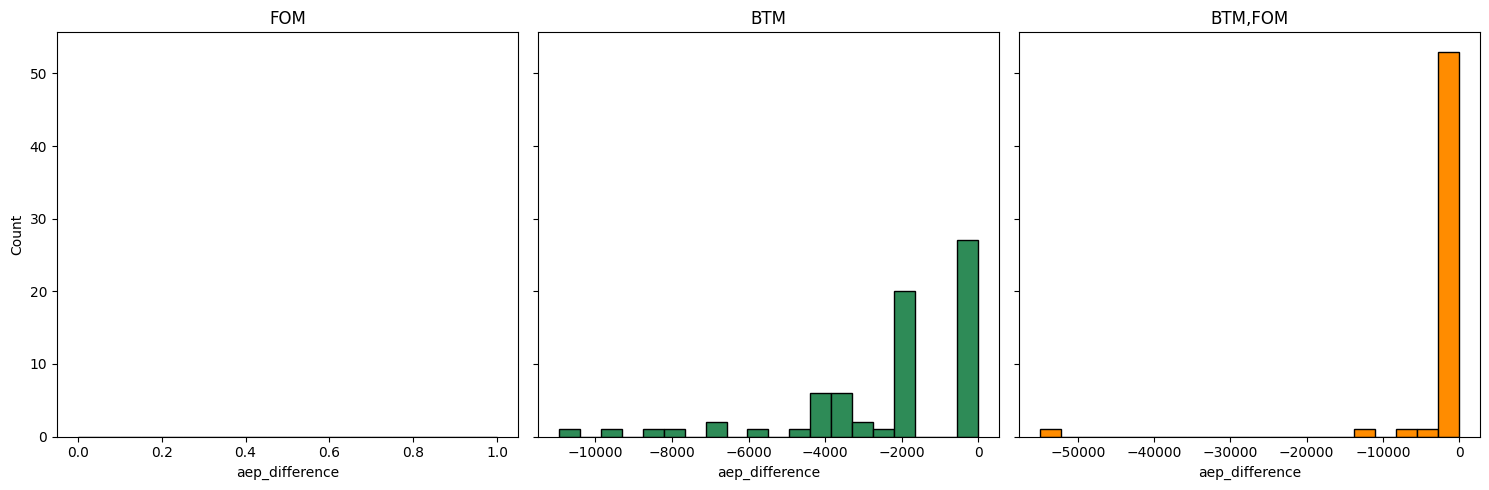

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  # 1 row, 3 columns

# Histogram for FOM
axes[0].hist(agent.loc[agent['application'] == 'FOM', 'aep_diff'], bins=20, color='steelblue', edgecolor='black')
axes[0].set_title("FOM")
axes[0].set_xlabel("aep_difference")

# Histogram for BTM
axes[1].hist(agent.loc[agent['application'] == 'BTM', 'aep_diff'], bins=20, color='seagreen', edgecolor='black')
axes[1].set_title("BTM")
axes[1].set_xlabel("aep_difference")

# Histogram for BTM,FOM
axes[2].hist(agent.loc[agent['application'] == 'BTM, FOM', 'aep_diff'], bins=20, color='darkorange', edgecolor='black')
axes[2].set_title("BTM,FOM")
axes[2].set_xlabel("aep_difference")

# Shared Y label
axes[0].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [11]:
profile = agent.groupby("countyfp", as_index=False).agg(
    {
        "wind_generation_hourly": lambda x: np.sum(np.stack(x), axis=0),
    }
)

timeseries_result = profile["wind_generation_hourly"].map(np.sum).sum()
normal_result=agent["wind_aep_kwh"].sum().squeeze()
percent_diff = (timeseries_result - normal_result) / normal_result * 100

print(
    "Timeseries result:\t{timeseries_result:,.1f}\nNormal Result:\t\t{normal_result:,.1f}\nPercent Difference:\t{percent_diff:.2f}%".format(
        timeseries_result=timeseries_result,
        normal_result=normal_result,
        percent_diff=percent_diff,
    )
)

Timeseries result:	2,875,197.5
Normal Result:		3,166,202.5
Percent Difference:	-9.19%


In [12]:
usecols = np.arange(1,23,1)
cambium = pd.read_excel('cambium_lrmer.xlsx', skiprows=348, usecols=usecols)
cambium

,Hour of the year,Hour of the day,Day of the year,Month,CAISO,ERCOT,FRCC,ISONE,MISO_Central,MISO_North,...,NorthernGrid_South,NorthernGrid_West,NYISO,PJM_East,PJM_West,SERTP,SPP_North,SPP_South,WestConnect_North,WestConnect_South
0,0,0,1,1,62.606263,85.719090,280.049488,39.614664,74.532475,116.533351,...,166.545468,37.781615,27.007267,166.624627,127.378210,155.263487,62.660061,83.356807,96.505117,140.601000
1,1,1,1,1,63.637805,76.908226,296.869603,35.353371,73.073261,110.693440,...,180.964657,37.356255,21.055874,162.505422,129.495007,159.911005,56.838945,81.694430,103.795394,148.759906
2,2,2,1,1,62.798462,85.091676,301.534550,34.429759,72.890476,108.796838,...,174.531651,37.854462,21.809215,161.859571,114.037363,152.977441,57.342368,83.600340,96.724060,146.008065
3,3,3,1,1,60.049943,79.110962,306.006535,34.012740,79.796634,101.865428,...,177.411123,36.561680,22.543722,165.130926,115.978380,160.540057,54.165621,84.514635,101.372368,146.472693
4,4,4,1,1,56.907477,80.934550,304.200976,37.344986,83.865263,109.192337,...,172.789877,37.644235,23.767901,168.568967,115.100356,154.620447,60.349917,82.166622,98.295822,141.294476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8755,19,365,12,65.695251,103.898244,273.806922,58.066149,113.306730,176.628068,...,203.698968,52.430069,33.297662,223.942105,158.178881,186.000868,123.913605,106.184283,132.158143,152.963730
8756,8756,20,365,12,69.374009,116.479442,274.387694,57.199932,114.244288,172.999196,...,200.014820,49.560651,32.883325,220.090550,151.419339,185.336453,120.201049,109.729579,131.400058,149.146930
8757,8757,21,365,12,67.403887,111.891960,277.779535,56.022708,107.667483,168.204509,...,200.117141,48.035873,30.566802,214.774319,149.550015,183.578163,113.586588,110.838973,131.337302,148.594116
8758,8758,22,365,12,70.207015,120.282709,281.530075,52.484059,106.799700,167.027953,...,202.447602,46.855934,28.683450,208.937616,153.372179,186.889352,113.632019,110.866836,129.456831,150.630012


In [13]:
usecols = np.arange(4,23,1)
cambiumTOD = pd.read_excel('cambium_lrmer.xlsx', skiprows=26, usecols=usecols, skipfooter=9058)
cambiumTOD

,Hour of the day,CAISO,ERCOT,FRCC,ISONE,MISO_Central,MISO_North,MISO_South,NorthernGrid_East,NorthernGrid_South,NorthernGrid_West,NYISO,PJM_East,PJM_West,SERTP,SPP_North,SPP_South,WestConnect_North,WestConnect_South
0,0,45.129892,102.338194,320.409024,43.865899,72.785663,91.652243,180.785767,114.057186,164.077950,31.225013,26.404594,177.795171,94.528586,171.080962,58.887291,87.583925,94.954114,153.178860
1,1,45.442322,97.058205,328.156415,41.875484,71.912888,87.313681,177.404111,112.628719,167.159301,30.941120,25.914922,174.523082,89.959195,171.369632,55.925343,88.132533,94.554916,161.425465
2,2,44.333198,96.190469,330.001360,40.889271,72.339581,85.551314,177.540826,113.239744,171.265675,31.023671,25.123915,173.847404,87.966985,171.219329,55.076717,88.802859,95.734225,162.469665
3,3,44.635132,97.272735,328.813828,40.405455,74.653843,86.508003,179.708756,113.702242,171.597717,30.670271,25.801921,176.120019,92.664671,172.614099,57.205410,91.781937,95.348273,161.908879
4,4,42.633509,100.257427,328.908131,40.018014,74.724219,89.415786,180.655584,114.964286,172.204724,30.252100,26.705930,180.419625,95.089793,173.054530,57.755507,92.155224,94.684790,162.179702
5,5,31.311337,97.626242,311.727759,38.677733,68.575975,87.083639,146.865222,112.393820,157.582484,28.282694,26.574096,178.054995,89.844818,166.226466,58.090558,89.214311,87.293756,145.929918
6,6,22.989809,69.186769,175.880571,39.607720,63.706513,84.578136,99.652061,110.002895,116.271585,23.732328,27.402770,166.270184,85.208241,121.518861,61.159952,73.077745,78.656595,103.093296
7,7,15.479293,43.779372,83.957615,40.030607,56.863988,81.819049,73.446833,106.882030,84.113726,22.084090,27.609939,151.507700,81.017771,86.067539,64.430363,60.529156,68.403576,81.953373
8,8,13.069791,36.652640,64.062040,42.323600,54.225413,78.693288,65.205830,105.592111,58.003127,21.144273,27.496938,144.325752,76.474406,66.382223,64.104758,55.177937,62.200638,71.935107
9,9,11.984859,33.458704,63.146946,43.525957,54.186837,78.469263,64.765391,104.942909,49.777362,21.255988,27.082601,142.727409,74.909354,61.804939,66.855167,51.690983,60.455272,71.066464


In [14]:
fips = pd.read_csv('Cambium_FIPS.csv')
fips['County FIPS'] = fips['County FIPS'].astype(str)
fips['State FIPS'] = fips['State FIPS'].astype(str)
fips['GEOID'] = '0' 
for i in range(len(fips)):
  if len(fips.loc[i, 'County FIPS']) ==1:
    fips.loc[i, 'GEOID'] = fips.loc[i, 'State FIPS'] + '00' + fips.loc[i, 'County FIPS']
  if len(fips.loc[i, 'County FIPS']) ==2:
    fips.loc[i, 'GEOID'] = fips.loc[i, 'State FIPS'] + '0' + fips.loc[i, 'County FIPS']
  if len(fips['County FIPS'][i]) ==3:
    fips.loc[i, 'GEOID'] = fips.loc[i, 'State FIPS'] + fips.loc[i, 'County FIPS']
  if len(fips.loc[i, 'State FIPS']) ==1:
    fips.loc[i, 'GEOID'] = '0' + fips.loc[i, 'GEOID']
fips['County'] = fips['County'] + ", " + fips['State']

fips = fips[['Cambium GEA', 'GEOID']] #we care about cambium GEA and GEOID only i think
fips

,Cambium GEA,GEOID
0,FRCC,12011
1,MISO_South,28055
2,SPP_North,31051
3,SERTP,28103
4,NorthernGrid_West,41051
...,...,...
3104,SERTP,47023
3105,SERTP,13255
3106,MISO_North,27143
3107,PJM_East,51027


In [15]:
btm = fips.rename(columns={"GEOID":"countyfp"}).merge(agent, how='right', on='countyfp')
btm

,Cambium GEA,countyfp,gid,run_id,statefp,turbine_class,wind_aep_kwh,techpot_kw,capacity_kw,application,rev_gid_wind,geom,rev_index_wind,cf_profile_hourly,wind_generation_hourly,aep_high_res,aep_diff
0,NorthernGrid_West,53023,3fdf050c-3a2c-4201-9775-9edebd741e60,6,53,res,12139.356445,1000.0,2.5,BTM,847127,0101000020E6100000000000E0F9605DC000000080C03D...,262966,"[0.059, 0.229, 0.68, 0.626, 0.664, 0.687, 0.64...","[0.1475, 0.5725, 1.7000000000000002, 1.565, 1....",8844.2400,-3295.116445
1,NorthernGrid_West,53023,515f6215-08fa-4e35-9618-ef4d4e7a0503,6,53,res,10355.147461,250.0,2.5,BTM,829589,0101000020E6100000000000002C735DC0000000207042...,254400,"[0.12, 0.272, 0.569, 0.626, 0.705, 0.732, 0.74...","[0.3, 0.68, 1.4224999999999999, 1.565, 1.7625,...",8244.4625,-2110.684961
2,NorthernGrid_West,53023,297144ca-55a0-4e86-ac2c-430d63aef9ad,6,53,res,9050.542969,2.5,2.5,BTM,841281,0101000020E610000000000000A5645DC0000000C0DA3C...,260108,"[0.056, 0.184, 0.677, 0.661, 0.744, 0.778, 0.7...","[0.14, 0.45999999999999996, 1.6925000000000001...",9050.5525,0.009531
3,NorthernGrid_West,53023,f2bc3751-4357-4481-9aaf-2435c5172089,6,53,res,18882.521484,5.0,5.0,BTM,849074,0101000020E6100000000000007F5B5DC0000000C09238...,263917,"[0.078, 0.339, 0.641, 0.63, 0.645, 0.683, 0.62...","[0.39, 1.695, 3.205, 3.15, 3.225, 3.415, 3.115...",18882.4250,-0.096484
4,NorthernGrid_West,53023,58ad8c55-eb3b-494d-b902-917edb872b26,6,53,res,9866.866211,10.0,2.5,BTM,852981,0101000020E610000000000080B65B5DC000000020E44D...,265835,"[0.017, 0.123, 0.492, 0.739, 0.664, 0.713, 0.7...","[0.0425, 0.3075, 1.23, 1.8475, 1.6600000000000...",9866.8750,0.008789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,NorthernGrid_West,53023,08640c08-17ac-4130-834f-f885cd19e271,6,53,res,11801.955078,100.0,2.5,"BTM, FOM",835428,0101000020E61000000000000009655DC0000000C02C2F...,257245,"[0.32, 0.264, 0.229, 0.158, 0.168, 0.081, 0.08...","[0.8, 0.66, 0.5725, 0.395, 0.42000000000000004...",10050.7050,-1751.250078
123,NorthernGrid_West,53023,97ba06cf-df38-403b-86dd-667483c8c9db,6,53,res,8915.791992,2.5,2.5,"BTM, FOM",839332,0101000020E610000000000000A0655DC000000060673C...,259155,"[0.071, 0.207, 0.625, 0.59, 0.715, 0.744, 0.73...","[0.1775, 0.5175, 1.5625, 1.4749999999999999, 1...",8915.6875,-0.104492
124,NorthernGrid_West,53023,e96346bf-0f97-4d80-9fd1-46126a05a654,6,53,res,8915.791992,2.5,2.5,"BTM, FOM",839332,0101000020E6100000000000C0A7645DC000000040BC3C...,259155,"[0.071, 0.207, 0.625, 0.59, 0.715, 0.744, 0.73...","[0.1775, 0.5175, 1.5625, 1.4749999999999999, 1...",8915.6875,-0.104492
125,NorthernGrid_West,53023,81b21802-e7b0-46e6-9e2e-f43866bda5ee,6,53,res,9289.283203,50.0,2.5,"BTM, FOM",851031,0101000020E610000000000060A95C5DC0000000001E4E...,264879,"[0.032, 0.261, 0.587, 0.735, 0.64, 0.645, 0.65...","[0.08, 0.6525000000000001, 1.4674999999999998,...",7624.0150,-1665.268203


In [16]:
btm['hourly_emissions'] = btm.apply(
    lambda row: row['wind_generation_hourly'] * cambium[row['Cambium GEA']].values,
    axis=1
)

btm['annual_emissions'] = np.sum(np.stack(btm['hourly_emissions'].values), axis=1)

hour_of_day = np.tile(np.arange(24), 365)  # 365 * 24 = 8760
def average_by_hour(x):
    return pd.Series(x).groupby(hour_of_day).mean().values  # returns a 24-element array
btm['TOD_generation'] = btm['wind_generation_hourly'].apply(average_by_hour)
btm['TOD_emissions'] = btm.apply(
    lambda row: row['TOD_generation'] * cambiumTOD[row['Cambium GEA']].values,
    axis=1
)

btm

,Cambium GEA,countyfp,gid,run_id,statefp,turbine_class,wind_aep_kwh,techpot_kw,capacity_kw,application,...,geom,rev_index_wind,cf_profile_hourly,wind_generation_hourly,aep_high_res,aep_diff,hourly_emissions,annual_emissions,TOD_generation,TOD_emissions
0,NorthernGrid_West,53023,3fdf050c-3a2c-4201-9775-9edebd741e60,6,53,res,12139.356445,1000.0,2.5,BTM,...,0101000020E6100000000000E0F9605DC000000080C03D...,262966,"[0.059, 0.229, 0.68, 0.626, 0.664, 0.687, 0.64...","[0.1475, 0.5725, 1.7000000000000002, 1.565, 1....",8844.2400,-3295.116445,"[5.57278819881689, 21.386455994885797, 64.3525...",231111.070959,"[0.9239315068493151, 0.8856849315068492, 0.868...","[28.849773537614386, 27.4040837229621, 26.9412..."
1,NorthernGrid_West,53023,515f6215-08fa-4e35-9618-ef4d4e7a0503,6,53,res,10355.147461,250.0,2.5,BTM,...,0101000020E6100000000000002C735DC0000000207042...,254400,"[0.12, 0.272, 0.569, 0.626, 0.705, 0.732, 0.74...","[0.3, 0.68, 1.4224999999999999, 1.565, 1.7625,...",8244.4625,-2110.684961,"[11.334484472169946, 25.402253408772648, 53.84...",210034.346520,"[0.8703835616438356, 0.8234520547945205, 0.832...","[27.17773823940194, 25.478528818416176, 25.833..."
2,NorthernGrid_West,53023,297144ca-55a0-4e86-ac2c-430d63aef9ad,6,53,res,9050.542969,2.5,2.5,BTM,...,0101000020E610000000000000A5645DC0000000C0DA3C...,260108,"[0.056, 0.184, 0.677, 0.661, 0.744, 0.778, 0.7...","[0.14, 0.45999999999999996, 1.6925000000000001...",9050.5525,0.009531,"[5.289426087012642, 17.183877305934438, 64.068...",234757.094661,"[0.9507191780821918, 0.8907054794520548, 0.905...","[29.68621892662805, 27.559425099258842, 28.095..."
3,NorthernGrid_West,53023,f2bc3751-4357-4481-9aaf-2435c5172089,6,53,res,18882.521484,5.0,5.0,BTM,...,0101000020E6100000000000007F5B5DC0000000C09238...,263917,"[0.078, 0.339, 0.641, 0.63, 0.645, 0.683, 0.62...","[0.39, 1.695, 3.205, 3.15, 3.225, 3.415, 3.115...",18882.4250,-0.096484,"[14.734829813820932, 63.31885224686712, 121.32...",491916.419162,"[2.069849315068493, 1.960958904109589, 1.92616...","[64.63107227541619, 60.674264711809215, 59.756..."
4,NorthernGrid_West,53023,58ad8c55-eb3b-494d-b902-917edb872b26,6,53,res,9866.866211,10.0,2.5,BTM,...,0101000020E610000000000080B65B5DC000000020E44D...,265835,"[0.017, 0.123, 0.492, 0.739, 0.664, 0.713, 0.7...","[0.0425, 0.3075, 1.23, 1.8475, 1.6600000000000...",9866.8750,0.008789,"[1.6057186335574092, 11.487048416467042, 46.56...",255595.375532,"[1.0751986301369862, 1.0512328767123287, 1.028...","[33.573091465603866, 32.526322556648545, 31.91..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,NorthernGrid_West,53023,08640c08-17ac-4130-834f-f885cd19e271,6,53,res,11801.955078,100.0,2.5,"BTM, FOM",...,0101000020E61000000000000009655DC0000000C02C2F...,257245,"[0.32, 0.264, 0.229, 0.158, 0.168, 0.081, 0.08...","[0.8, 0.66, 0.5725, 0.395, 0.42000000000000004...",10050.7050,-1751.250078,"[30.225291925786525, 24.65512830851463, 21.671...",267345.239542,"[1.1356575342465753, 1.1060342465753423, 1.059...","[35.4609215471236, 34.22193831619861, 32.88466..."
123,NorthernGrid_West,53023,97ba06cf-df38-403b-86dd-667483c8c9db,6,53,res,8915.791992,2.5,2.5,"BTM, FOM",...,0101000020E610000000000000A0655DC000000060673C...,259155,"[0.071, 0.207, 0.625, 0.59, 0.715, 0.744, 0.73...","[0.1775, 0.5175, 1.5625, 1.4749999999999999, 1...",8915.6875,-0.104492,"[6.706236646033885, 19.33186196917624, 59.1475...",229665.663679,"[0.9359863013698629, 0.8966575342465755, 0.906...","[29.22618465616822, 27.743588340734785, 28.116..."
124,NorthernGrid_West,53023,e96346bf-0f97-4d80-9fd1-46126a05a654,6,53,res,8915.791992,2.5,2.5,"BTM, FOM",...,0101000020E6100000000000C0A7645DC000000040BC3C...,259155,"[0.071, 0.207, 0.625, 0.59, 0.715, 0.744, 0.73...","[0.1775, 0.5175, 1.5625, 1.4749999999999999, 1...",8915.6875,-0.104492,"[6.706236646033885, 19.33186196917624, 59.1475...",229665.663679,"[0.9359863013698629, 0.8966575342465755, 0.906...","[29.22618465616822, 27.743588340734785, 28.116..."
125

In [17]:
county_emissions = btm.groupby("countyfp").agg({
    "annual_emissions": "sum",
    "Cambium GEA": "first"  # or "mode", "max", etc., depending on what you want
}).reset_index()
county_emissions

,countyfp,annual_emissions,Cambium GEA
0,53023,7.482656e+07,NorthernGrid_West


/tmp/ipykernel_2335695/3863610390.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


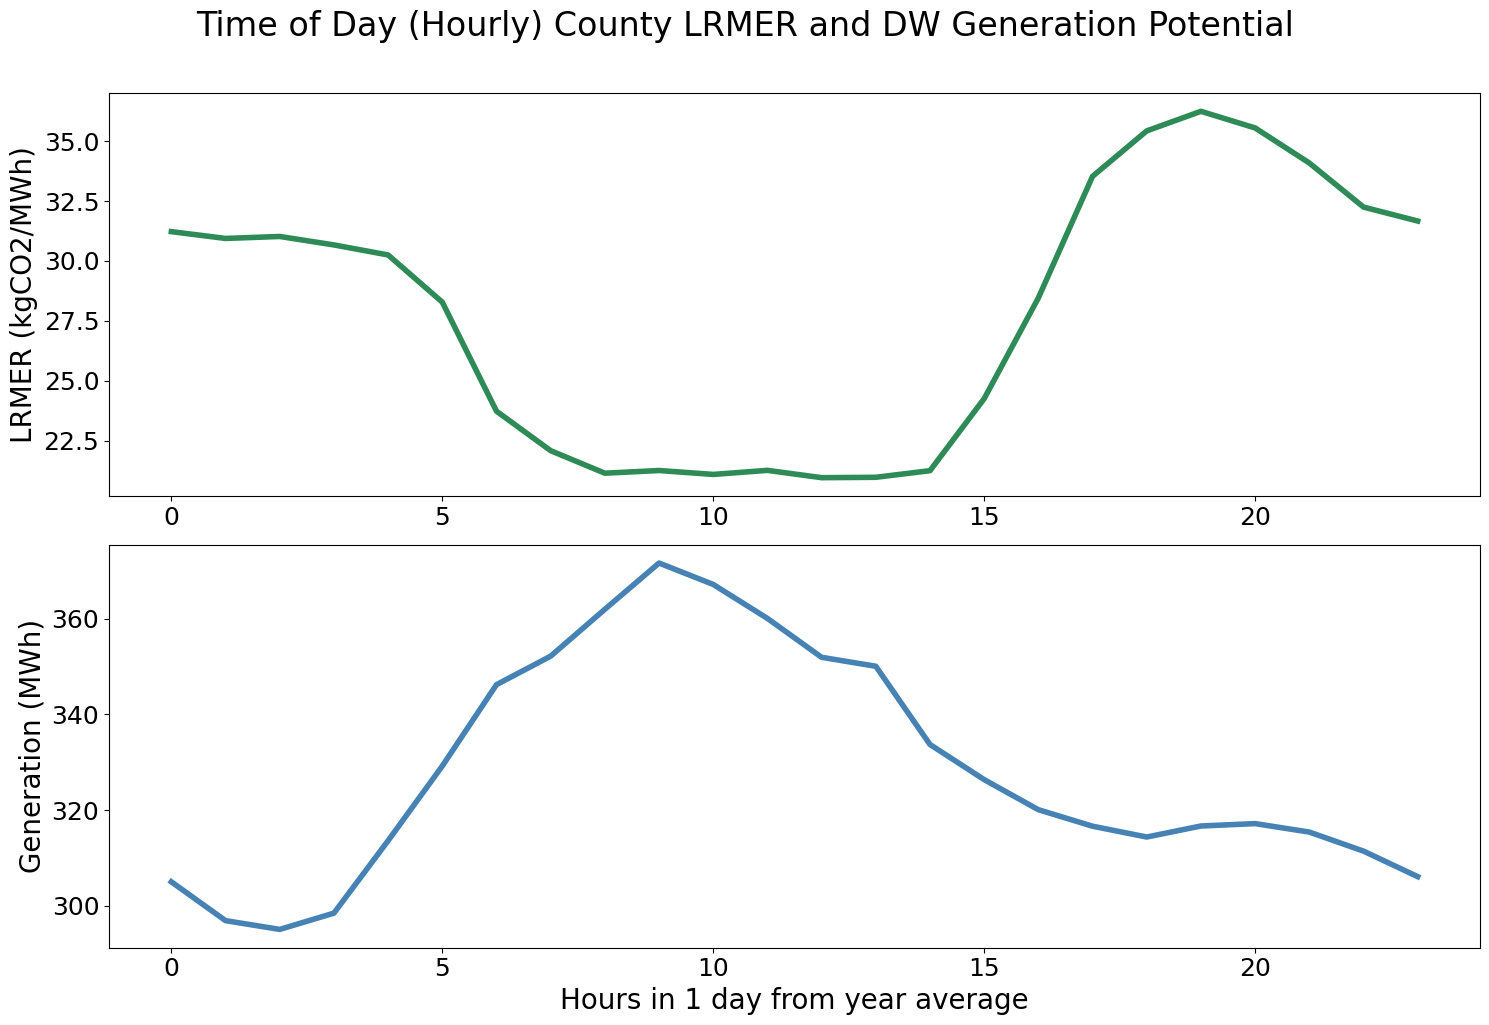

In [18]:
#----------now plot hourly, daily, monthly wind generation to compare (and maybe hourly, daily, monthly emissions?)--------------
#----------now finally, hourly/daily/monthly lrmer! ------------

import matplotlib.pyplot as plt

# --- Create figure with 2 subplots ---
fig, axs = plt.subplots(2, 1, figsize=(15, 10), constrained_layout=True)
hours = np.arange(0, 24, 1)  # tod

hourly_lrmer = np.stack(county_emissions.apply(
    lambda row: cambiumTOD[row['Cambium GEA']].values,
    axis=1
))
hourly_county_gen = np.sum(np.stack(btm['TOD_generation'].values), axis=0)

# plot hourly
axs[0].plot(hours, hourly_lrmer[0], color='seagreen', linewidth=4)
axs[0].set_ylabel('LRMER (kgCO2/MWh)', fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=18)

axs[1].plot(hours, hourly_county_gen, color='steelblue', linewidth=4)
axs[1].set_xlabel('Hours in 1 day from year average', fontsize=20)
axs[1].set_ylabel('Generation (MWh)', fontsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=18)

# title
plt.suptitle('Time of Day (Hourly) County LRMER and DW Generation Potential',
             fontsize=24, y=1.02)

plt.tight_layout()
plt.show()

/tmp/ipykernel_2335695/2473316094.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


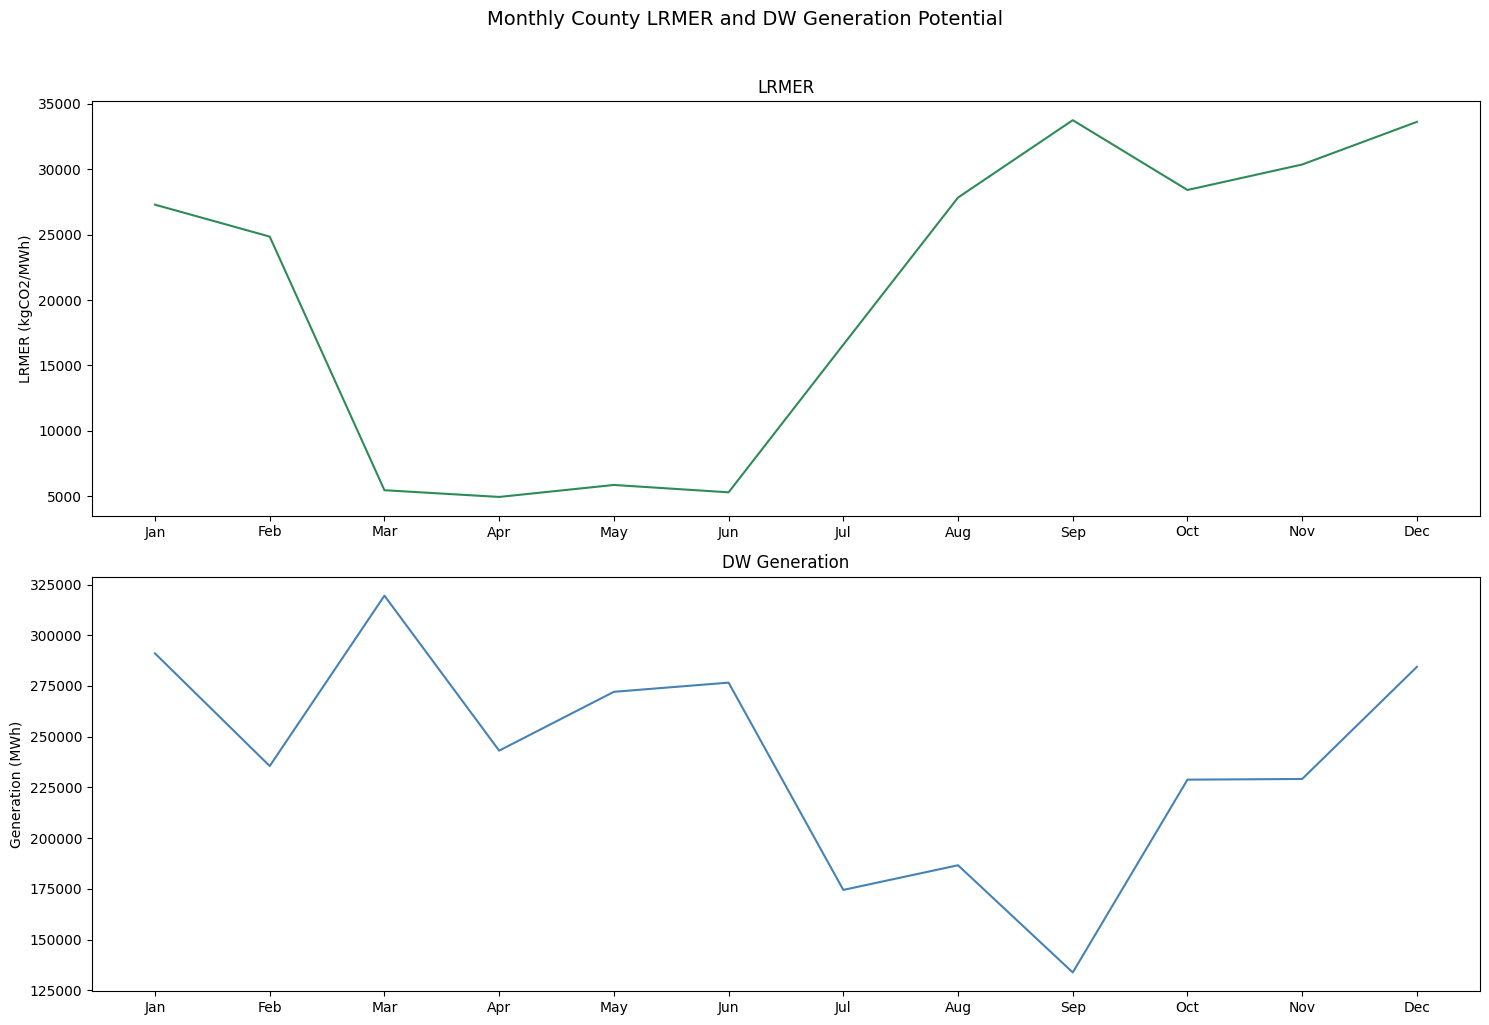

In [19]:
# --- monthly data ---
dates = pd.date_range(start='2035-01-01', periods=8760, freq='h')
hourly_county_gen_formonthly = np.sum(np.stack(btm['wind_generation_hourly'].values), axis=0)
hourly_series_gen = pd.Series(hourly_county_gen_formonthly, index=dates)
monthly_county_gen = hourly_series_gen.resample('ME').sum()
monthly_county_gen.index = monthly_county_gen.index.strftime('%b')  # e.g., Jan, Feb

# --- monthly data ---
hourly_lrmer_formonthly = np.stack(county_emissions.apply(
    lambda row: cambium[row['Cambium GEA']].values,
    axis=1
))
hourly_series = pd.Series(hourly_lrmer_formonthly[0], index=dates)
monthly_lrmer = hourly_series.resample('ME').sum()
monthly_lrmer.index = monthly_lrmer.index.strftime('%b')  # e.g., Jan, Feb

# --- Create figure with 3 subplots ---
fig, axs = plt.subplots(2, 1, figsize=(15, 10), constrained_layout=True)

# plot monthly
axs[1].plot(monthly_county_gen.index, monthly_county_gen, color='steelblue')
axs[1].set_title('DW Generation')
axs[1].set_ylabel('Generation (MWh)')

# plot monthly
axs[0].plot(monthly_lrmer.index, monthly_lrmer, color='seagreen')
axs[0].set_title('LRMER')
axs[0].set_ylabel('LRMER (kgCO2/MWh)')

plt.suptitle('Monthly County LRMER and DW Generation Potential', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [20]:
def cosine_similarity(A, B):
    # The time-series data sets should be normalized.
    A_norm = (A - np.mean(A)) / np.std(A)
    B_norm = (B - np.mean(B)) / np.std(B)

    # Determining the dot product of the normalized time series data sets.
    dot_product = np.dot(A_norm, B_norm)

    # Determining the Euclidean norm for each normalized time-series data collection.
    norm_A = np.linalg.norm(A_norm)
    norm_B = np.linalg.norm(B_norm)

    # Calculate the cosine similarity of the normalized time series data 
    # using the dot product and Euclidean norms. setse-series data set
    cosine_sim = dot_product / (norm_A * norm_B)

    return cosine_sim

In [21]:
county_emissions['hour_cs'] = cosine_similarity(hourly_lrmer[0], hourly_county_gen)
county_emissions['month_cs'] = cosine_similarity(monthly_lrmer, monthly_county_gen)
county_emissions.to_csv("county_emissions.csv", index=False)
county_emissions

,countyfp,annual_emissions,Cambium GEA,hour_cs,month_cs
0,53023,7.482656e+07,NorthernGrid_West,-0.836394,-0.439672


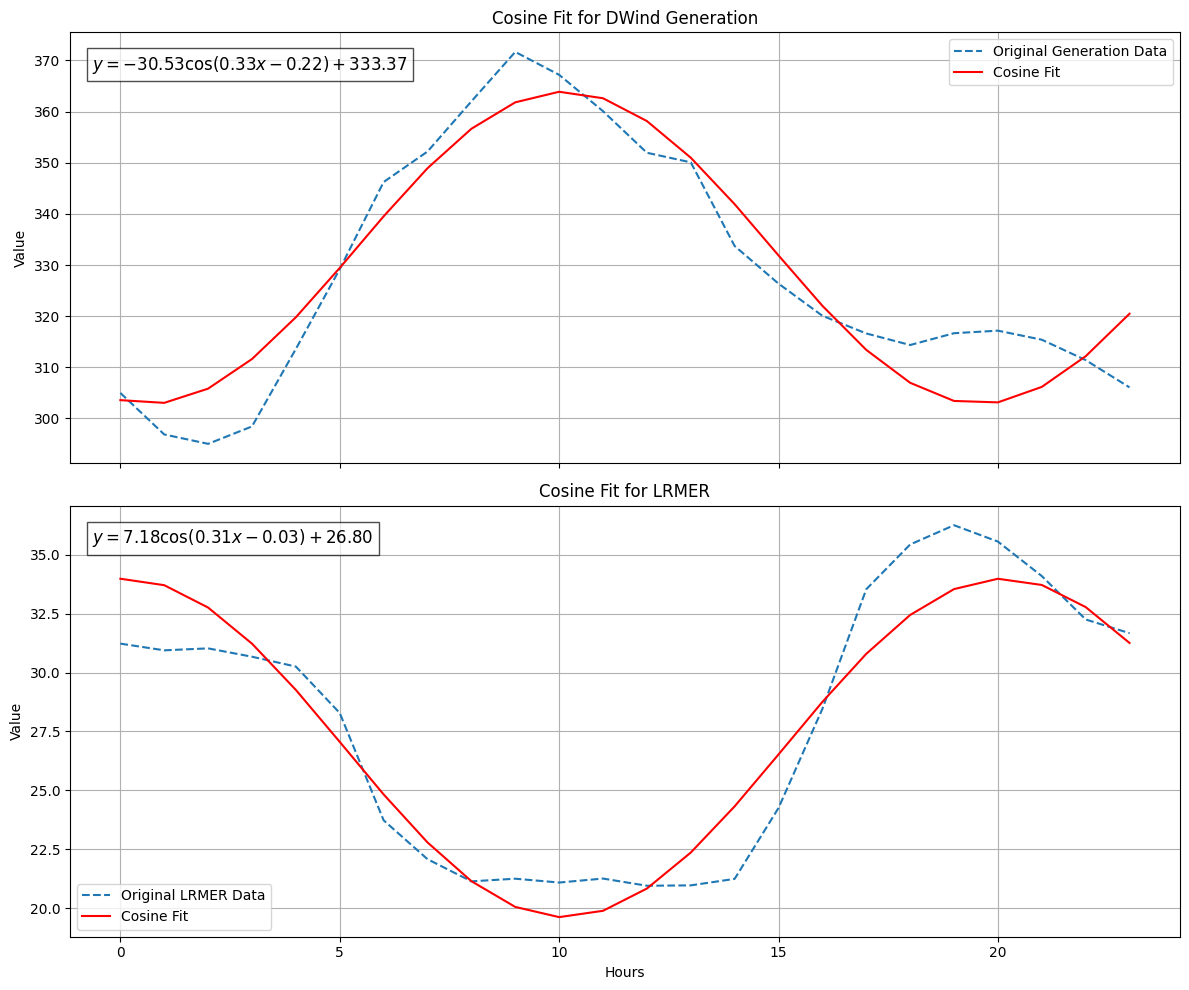

Dataset 1 (county gen): Amplitude=-30.53, Frequency=0.33, Phase=-0.22, Offset=333.37
Dataset 2 (lrmer[0]):   Amplitude=7.18, Frequency=0.31, Phase=-0.03, Offset=26.80
Phase difference (lrmer - gen) = 0.18


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.optimize import curve_fit

# --- Define cosine function ---
def cosine_func(x, amplitude, frequency, phase, offset):
    return amplitude * np.cos(frequency * x + phase) + offset

# --- Helper function to fit cosine and return parameters + fit curve ---
def fit_cosine(x_data, y_data):
    N = len(y_data)
    yf = fft(y_data)
    xf = np.fft.fftfreq(N, x_data[1] - x_data[0])

    # Dominant frequency (ignoring DC at index 0)
    idx = np.argmax(np.abs(yf[1:N//2])) + 1
    estimated_frequency = xf[idx] * 2 * np.pi  # angular freq

    # Amplitude & offset estimates
    estimated_amplitude = (np.max(y_data) - np.min(y_data)) / 2
    estimated_offset = np.mean(y_data)

    # Initial guess: [A, ω, φ, offset]
    p0 = [estimated_amplitude, estimated_frequency, 0, estimated_offset]

    popt, _ = curve_fit(cosine_func, x_data, y_data, p0=p0)
    return popt, cosine_func(x_data, *popt)

# --- Data sets ---
x_data1 = hours
y_data1 = hourly_county_gen

x_data2 = hours
y_data2 = hourly_lrmer[0]

# --- Fit both datasets ---
params1, fit_curve1 = fit_cosine(x_data1, y_data1)
params2, fit_curve2 = fit_cosine(x_data2, y_data2)

phase_gen = params1[2]   # phase for county generation fit
phase_lrmer = params2[2] # phase for lrmer fit

# --- Compute phase difference ---
phase_diff = phase_lrmer - phase_gen

# --- Plot ---
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Helper to format equation text
def format_eq(params):
    A, w, phi, C = params
    return (r"$y = {:.2f}\cos({:.2f}x {:+.2f}) {:+.2f}$"
            .format(A, w, phi, C))

# First dataset
axs[0].plot(x_data1, y_data1, linestyle='dashed', label="Original Generation Data")
axs[0].plot(x_data1, fit_curve1, color="red", label="Cosine Fit")
axs[0].set_title("Cosine Fit for DWind Generation")
axs[0].set_ylabel("Value")
axs[0].grid(True)
axs[0].legend()
axs[0].text(0.02, 0.95, format_eq(params1), transform=axs[0].transAxes,
            fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Second dataset
axs[1].plot(x_data2, y_data2, linestyle='dashed', label="Original LRMER Data")
axs[1].plot(x_data2, fit_curve2, color="red", label="Cosine Fit")
axs[1].set_title("Cosine Fit for LRMER")
axs[1].set_xlabel("Hours")
axs[1].set_ylabel("Value")
axs[1].grid(True)
axs[1].legend()
axs[1].text(0.02, 0.95, format_eq(params2), transform=axs[1].transAxes,
            fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

# --- Print fitted parameters ---
print("Dataset 1 (county gen): Amplitude={:.2f}, Frequency={:.2f}, Phase={:.2f}, Offset={:.2f}".format(*params1))
print("Dataset 2 (lrmer[0]):   Amplitude={:.2f}, Frequency={:.2f}, Phase={:.2f}, Offset={:.2f}".format(*params2))
print(f"Phase difference (lrmer - gen) = {phase_diff:.2f}")
